# 1 Введение

## 1.1 Постановка задачи

**Заказчик** -- золлотодобывающая компания
  
**Задача** -- подготовить прототип модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками

## 1.2 Исходные данные

### 1.2.1 Описание технологического процесса

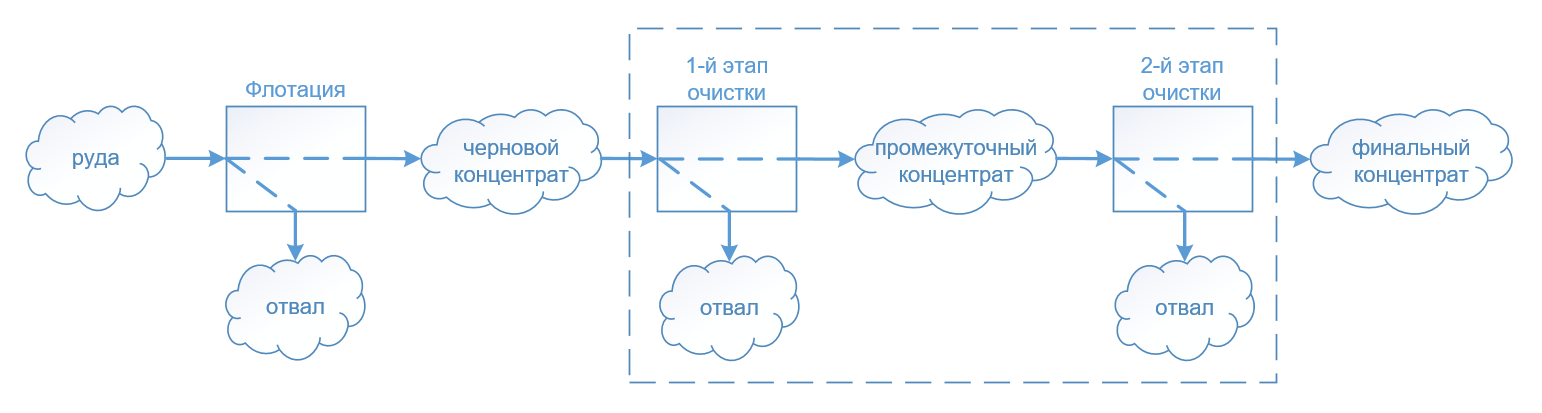

Добытая руда проходит первичную обработку, в результате чего получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.  
  
Описание стадий:
1. **Флотация**  
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов. На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. **Очистка**  
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.  
  
Эффективность обогащения необходимо рассчитывать по формуле:
$$
Recovery = \frac{C\cdot(F-T)}{F\cdot(C-T)}\cdot100\%
$$
где:  
C — доля золота в концентрате после флотации/очистки;  
F — доля золота в сырье/концентрате до флотации/очистки;  
T — доля золота в отвальных хвостах после флотации/очистки.  
  
Метрика качества работы модели -- **sMAPE** (симметричное среднее абсолютное процентное отклонение):
$$
\text{sMAPE} = \frac{1}{N}\sum_{i=1}^N\frac{|y_i - \hat{y}_i|}{(|y_i|+|\hat{y}_i|)\;/\; 2}\cdot100\%
$$  
  
Необходимо спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery`.  
  
Итоговая метрика складывается из двух величин:  
  
$$
\text{Итоговое sMAPE} = 25\%\cdot\text{sMAPE(rougher)}+75\%\cdot\text{sMAPE(final)}
$$

### 1.2.2 Переданные файлы
- gold_recovery_train.csv — обучающая выборка;
- gold_recovery_test.csv — тестовая выборка;
- gold_recovery_full.csv — исходные данные.
  
Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

### 1.2.3 Описание данных

**Технологический процесс**
- *Rougher feed* — исходное сырье;
- *Rougher additions* (или *reagent additions*) — флотационные реагенты: *Xanthate*, *Sulphate*, *Depressant*;
 - *Xanthate* — ксантогенат (промотер, или активатор флотации);
 - *Sulphate* — сульфат (на данном производстве сульфид натрия);
 - *Depressant* — депрессант (силикат натрия);
- *Rougher process* (англ. «грубый процесс») — флотация;
- *Rougher tails* — отвальные хвосты;
- *Float banks* — флотационная установка;
- *Cleaner process* — очистка;
- *Rougher Au* — черновой концентрат золота;
- *Final Au* — финальный концентрат золота.
  
**Параметры этапов**
- *air amount* — объём воздуха;
- *fluid levels* — уровень жидкости;
- *feed size* — размер гранул сырья;
- *feed rate* — скорость подачи.
  
**Наименование признаков**  
Наименование признаков формируется следующим образом:
`[этап].[тип_параметра].[название_параметра]`  
  
<u>Пример</u>: `rougher.input.feed_ag` 
  
Возможные значения для блока `[этап]`:
- *rougher* — флотация;
- *primary_cleaner* — первичная очистка;
- *secondary_cleaner* — вторичная очистка;
- *final* — финальные характеристики.
  
Возможные значения для блока `[тип_параметра]`:
- *input* — параметры сырья;
- *output* — параметры продукта;
- *state* — параметры, характеризующие текущее состояние этапа;
- *calculation* — расчётные характеристики.

## 1.3 План обработки и анализа данных

### 1.3.1 Решения по ML-структуре технологического процесса

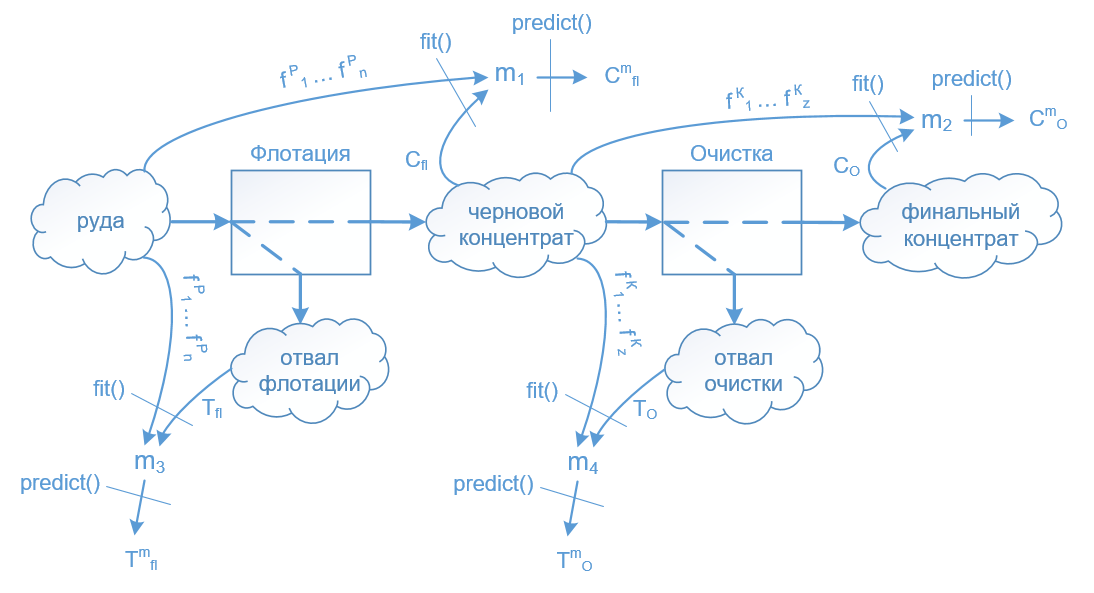

Для упрощения ML-структуры технологического процесса (ТП) объединим фазы очистки в одну, считая их технологически эквивалентными. В результате данного допущения технологический процесс будет включать в себя две стадии:
- флотацию (с выходом чернового концентрата и отвала флотации);
- очистку (с выходом финального концентрата и отвала очистки).
  
ML-структура ТП будет включать в себя следущие модели:
- $m_1$ - модель предсказания содержания золота в черновом концентрате после флотации руды:
 - $C^m_{fl}$ -- прогнозируемое сдержание золота в черновом конденсате (предиктный признак, результат работы модели);
 - $f^P_1 ... f^P_n$ -- признаки, описывающие руду;
 - $C_{fl}$ -- целевой признак.  
   
- $m_3$ - модель предсказания содержания золота в отвале флотации:
 - $T^{m}_{fl}$ -- прогнозируемое сдержание золота в отвале флотации (предиктный признак, результат работы модели);
 - $f^{P}_1 ... f^{P}_n$ -- признаки, описывающие руду;
 - $T_{fl}$ -- целевой признак.   
   
- $m_2$ - модель предсказания содержания золота в финальном концентрате после очистки чернового конденсата:
 - $C^{m}_O$ -- прогнозируемое сдержание золота в финальном конденсате (предиктный признак, результат работы модели);
 - $f^{K}_1 ... f^{K}_z$ -- признаки, описывающие черновой концентрат;
 - $C_O$ -- целевой признак.  
  
- $m_4$ - модель предсказания содержания золота в отвале очистки:
 - $T^{m}_O$ -- прогнозируемое сдержание золота в отвале очистки (предиктный признак, результат работы модели);
 - $f^{K}_1 ... f^{K}_z$ -- признаки, описывающие черновой концентрат;
 - $T_O$ -- целевой признак.  
  
Таким образом, первый этап обработки руды будет описываться моделями $m_1$, $m_3$, а второй этап -- моделями $m_2$, $m_4$.  
  
Формулы расчёта эффективности обогащения примут вид:
$$
Recovery_{fl}^m = \frac{C^m_{fl}\cdot\bigl(F_P-T^m_{fl}\bigr)}{F_P\cdot\bigl(C^m_{fl}-T^m_{fl}\bigr)}\cdot100\%
$$
  
$$
Recovery_O^m = \frac{C^m_O\cdot\bigl(F_K-T^m_O\bigr)}{F_K\cdot\bigl(C^m_O-T^m_O\bigr)}\cdot100\%
$$

Величины $Recovery_{fl}^m$ и $Recovery_O^m$ объединяют в себе предиктные значения моделей $m_1\dots m_4$, поэтому ML-структура тех.процесса может быть ещё упрощена, поскольку в переданных данных присутствуют значения $Recovery_{fl}^m$ (rougher.output.recovery) и $Recovery_O^m$ (final.output.recovery), которые, по большому счёту, можно было бы добавить в набор данных в случае их отсутствия.

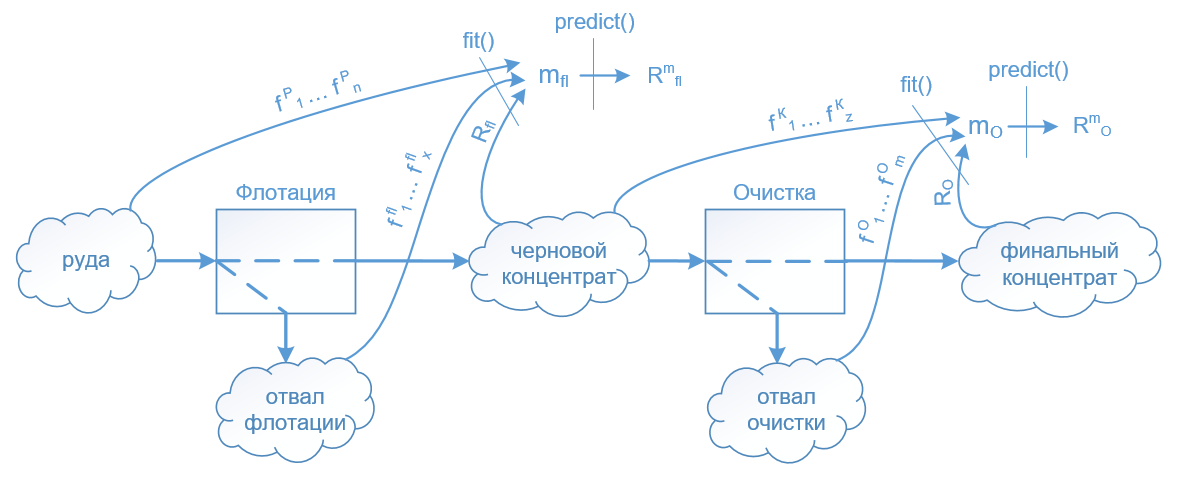

При этом инстурменты *sklearn* позволяют сосздавать мультивыходные модели машинного обучения, т.е. модели обучающиеся на нескольких целевых признаках и генерирующих, соответственно, несколько выходных предиктных признаков. Таким образом, модели $m_1\dots m_4$ вырождаются в одну модель с двумя целевеми и двумя предиктными (выходными) признаками

### 1.3.2 Предобработка данных
- обзор данных;
- корректировка имён столбцов (при необходимости);
- обнаружение и удаление пропусков:
 - выявить пропуски;
 - проанализировать причины их появления;
 - заполнить пропуски (приняв решение по алгоритму заполнения), либо удалить их;
- преобразование типов данных столбцов (при необходимости);
- удаление дубликатов строк.
  
Формирование обучащей и тестовой выборок по идентификаторам объектов соответствующих выборок, переданных Заказчиком.

### 1.3.3 Анализ данных
- проверить, что эффективность обогащения рассчитана правильно; для этого необходимо вычислите её на обучающей выборке для признака `rougher.output.recovery` -- найти MAE между собственными расчётами и значением признака;
- проанализировать, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки;
- сравнить распределения размеров гранул сырья на обучающей и тестовой выборках;
- исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом, в промежуточном и финальном концентратах.

### 1.3.4 Построение и обучение моделей
- написать функцию для вычисления итоговой sMAPE;
- обучить разные модели.

### 1.3.5 Тестирование модели
 - оценить качество моделей кросс-валидацией;
 - выбрать лучшую модель и проверьте её на тестовой выборке.

### 1.3.6 Вывод

## 1.4 Пользовательские функции

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer


pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 10
#pd.options.display.max_columns = 50
pd.options.mode.chained_assignment = None

In [2]:
def hists_plot(metal, metal_text, xlim=(), sum_metal=False, bins=50, figsize=(16,10), m_row=2, m_col=2):
    '''
    Функция отрисовки матрицы гистограмм с линией распределения плотности вероятности
    '''
    
    cell = 0
    stage = ['Руда', 'Черновой концентрат', 'Промежуточный концентрат', 'Финальный концентрат']
    
    fig, axs = plt.subplots(m_row, m_col, figsize=figsize, constrained_layout=True)
    sns.set(style="whitegrid")
    
    for row in range(m_row):
        for col in range(m_col):
            if sum_metal:
                d = metal[cell]
            else:
                d = full_data[metal[cell]]
                
            axs[row][col].set(xlim=xlim)
            sns.distplot(d, ax=axs[row][col], bins=bins, axlabel='Содержание '+ metal_text)
            ax2 = axs[row][col].twinx()
            sns.boxplot(x=d, ax=ax2)
            ax2.set(ylim=(-.5, 10))
            axs[row][col].set_title(stage[cell])
            cell += 1

In [3]:
def feed_hists_plot(bins=50, figsize=(16,5)):
    
    fig, axs = plt.subplots(1, 2, figsize=figsize, constrained_layout=True)
    sns.set(style="whitegrid")
    
    sns.distplot(train_data['rougher.input.feed_size'], ax=axs[0], bins=bins, kde_kws={"label": "train"})
    sns.distplot(test_data['rougher.input.feed_size'],
                 ax=axs[0], bins=bins, axlabel='Размер гранул руды', kde_kws={"label": "test"})
    
    sns.distplot(train_data['primary_cleaner.input.feed_size'], ax=axs[1], bins=bins, kde_kws={"label": "train"})
    sns.distplot(test_data['primary_cleaner.input.feed_size'],
                 ax=axs[1], bins=bins, axlabel='Размер гранул чернового концентрата', kde_kws={"label": "test"})

In [4]:
def sMAPE(y, y_pred):
    '''
    Функция рассчёта sMAPE
    '''
   
    result = np.sum(abs(np.array(y) - y_pred) / ((abs(np.array(y)) + abs(y_pred)) / 2) * 100, axis=0)
    
    return (0.25 * result[0] / len(y)) + (0.75 * result[1] / len(y))

# 2 Основная часть

## 2.1 Предобработка данных

Полный набор признаков объектов находится в наборе данных *gold_recovery_full*. Поскольку обучаущий и тестовый набор передал Заказчик состав объектов должен им соответствовать. При этом переданные обучающий и тестовый наборы могут быть не полными в части ряда признаков. Поэтому предобработку данных проведём на полном наборе данных, а затем выделим из него обучающую и тестовую выборки по идентификаторам объектов выборок, переданных Заказчиком. При этом состав признаков обучающей выборки приведём к составу признаков тестовой, поскольку в ней отстутствуют ряд признаков, которые формируются значительно позже

### 2.1.1 Обзор данных

In [5]:
full_data = pd.read_csv('gold_recovery_full.csv')

In [6]:
full_data.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,...,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
1,2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,...,13.99,-505.50,11.95,-501.33,10.04,-500.17,7.98,-500.58,14.00,-599.79
2,2016-01-15 02:00:00,6.06,10.21,5.38,42.66,68.12,10.51,0.95,16.21,2.26,...,14.02,-502.52,11.91,-501.13,10.07,-500.13,8.01,-500.52,14.03,-601.43
3,2016-01-15 03:00:00,6.05,9.98,4.86,42.69,68.35,10.42,0.88,16.53,2.15,...,14.04,-500.86,12.00,-501.19,9.97,-499.20,7.98,-500.26,14.01,-600.00
4,2016-01-15 04:00:00,6.15,10.14,4.94,42.77,66.93,10.36,0.79,16.53,2.06,...,14.03,-499.84,11.95,-501.05,9.93,-501.69,7.89,-500.36,14.00,-601.50


In [7]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [8]:
full_data_shape = full_data.shape

In [9]:
nans = pd.DataFrame(full_data.isna().sum() / full_data.shape[0] * 100, columns=['nans_percent']).sort_values(by='nans_percent')
nans.loc[nans['nans_percent'] == 0,:]

,nans_percent
date,0.00
primary_cleaner.input.feed_size,0.00


По итогам первого, общего взгляда на данные, можно сделать следующие выводы:

- набор данных состоит из 87 столбцов и 22716 строк;
- имена столбцов читабельны и соответствуют требованиям Заказчика;
- пропуски отсутствуют только в столбцах *date* и *primary_cleaner.input.feed_size*; во всех остальных столбцах имеются пропуски;  
- типы данных столбцов менять не требуется.

### 2.1.2 Обнаружение и удаление пропусков

Пропуски в данных -- они как кот Шрёдингера -- их нужно обязательно удалить, но удалять их нельзя:
- пропуски обязательно должны быть удалены в целевых признаках, потому что их наличие или, особенно, замена на некую агрегированную информацию ухудшат качество модели;
- пропуски в остальных признаках нужно стремиться заполнить, чтоб не терять информацию, которая будет удалена при удалении пропусков.  
Так и сделаем -- пропуски в целевых признаках удалим, а остальные заполним предыдущими по отношении к ним значениями (`df.fillna(method='ffill')`)

In [10]:
full_data.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)
full_data.fillna(method='ffill', inplace=True)
full_data.isna().sum().sum()

0

In [11]:
full_data.shape[0] / full_data_shape[0] * 100

85.57404472618418

Вместе с пропусками удалено 15% исходных данных. Не мало. Но таковы уж переданные данные -- основной объем пропусков пришёлся на целевые признаки

### 2.1.3 Удаление дубликатов строк

In [12]:
full_data.drop(columns=['date'], axis='columns').duplicated().sum()

0

Дубликаты строк отсутствуют

### 2.1.4 Формирование обучающей и тестовых выборок

In [13]:
customer_train_data = pd.read_csv('gold_recovery_train.csv')
customer_test_data = pd.read_csv('gold_recovery_test.csv')

In [14]:
test_columns = customer_test_data.columns.tolist()

In [15]:
diff_columns = []

for i in customer_train_data.columns.tolist():
    if not i in test_columns:
        diff_columns.append(i)
        
diff_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовой выборке недоступны некоторые расчетные (calculation) и выходные (output) характеристики процесса, т.к., по всей видимсоти, их невозможно получить/измерить во время протекания технологического процесса.

In [16]:
ids = full_data['date'].tolist()
(customer_train_data['date'].isin(ids).sum() - customer_train_data.shape[0]) / customer_train_data.shape[0] * 100

-16.079478054567023

In [17]:
(customer_test_data['date'].isin(ids).sum() - customer_test_data.shape[0]) / customer_test_data.shape[0] * 100

-9.665300546448087

В переданных Заказчиком выборках присутствуют объекты, которые мы удалили на этапе устранения пропусков.  
Сформируем новые обучающую и тестовую выборки из оставшихся значений. При этом состав столбцов приведем к составу столбцов тестовой выборки

In [18]:
train_data = full_data.loc[full_data['date'].isin(customer_train_data[customer_train_data['date'].isin(ids)]['date']), :]

In [19]:
train_data

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,...,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
1,2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,...,13.99,-505.50,11.95,-501.33,10.04,-500.17,7.98,-500.58,14.00,-599.79
2,2016-01-15 02:00:00,6.06,10.21,5.38,42.66,68.12,10.51,0.95,16.21,2.26,...,14.02,-502.52,11.91,-501.13,10.07,-500.13,8.01,-500.52,14.03,-601.43
3,2016-01-15 03:00:00,6.05,9.98,4.86,42.69,68.35,10.42,0.88,16.53,2.15,...,14.04,-500.86,12.00,-501.19,9.97,-499.20,7.98,-500.26,14.01,-600.00
4,2016-01-15 04:00:00,6.15,10.14,4.94,42.77,66.93,10.36,0.79,16.53,2.06,...,14.03,-499.84,11.95,-501.05,9.93,-501.69,7.89,-500.36,14.00,-601.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22711,2018-08-18 06:59:59,3.22,11.36,6.80,46.71,73.76,8.77,3.14,10.40,1.53,...,23.03,-501.17,20.01,-499.74,18.01,-499.83,13.00,-500.16,20.01,-501.30
22712,2018-08-18 07:59:59,3.20,11.35,6.86,46.87,69.05,8.90,3.13,10.55,1.61,...,22.96,-501.61,20.04,-500.25,18.00,-500.40,12.95,-499.90,19.97,-501.04
22713,2018-08-18 08:59:59,3.11,11.43,6.89,46.80,67.00,8.53,2.91,11.12,1.60,...,23.02,-501.71,19.95,-499.86,18.02,-500.45,13.02,-499.91,19.99,-501.52
22714,2018-08-18 09:59:59,3.37,11.63,6.80,46.41,65.52,8.78,2.82,10.46,1.60,...,23.02,-501.15,20.05,-500.31,17.98,-499.27,12.99,-499.98,20.01,-500.63


In [20]:
test_data = full_data.loc[full_data['date'].isin(customer_test_data[customer_test_data['date'].isin(ids)]['date']), :]

In [21]:
test_data

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
5521,2016-09-01 00:59:59,7.58,10.47,11.99,40.74,70.27,12.69,3.84,11.08,4.54,...,12.02,-497.80,8.02,-501.29,7.95,-432.32,4.87,-500.04,26.71,-499.71
5522,2016-09-01 01:59:59,7.81,10.58,12.22,39.60,68.91,12.83,3.92,11.13,4.68,...,12.06,-498.70,8.13,-499.63,7.96,-525.84,4.88,-500.16,25.02,-499.82
5523,2016-09-01 02:59:59,7.62,10.42,12.31,40.72,68.14,12.98,4.03,10.99,4.83,...,11.96,-498.77,8.10,-500.83,8.07,-500.80,4.91,-499.83,24.99,-500.62
5524,2016-09-01 03:59:59,8.55,10.50,13.07,39.29,67.78,12.45,3.78,11.16,4.97,...,12.03,-498.35,8.07,-499.47,7.90,-500.87,4.93,-499.96,24.95,-498.71
5525,2016-09-01 04:59:59,8.08,10.22,12.48,40.25,61.47,11.83,3.63,11.40,5.26,...,12.03,-500.79,8.05,-500.40,8.11,-509.53,4.96,-500.36,25.00,-500.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17204,2017-12-31 19:59:59,5.00,9.71,10.85,46.40,68.92,13.94,3.37,13.77,3.89,...,14.00,-500.16,12.07,-499.67,7.98,-499.52,5.93,-499.97,8.99,-499.76
17205,2017-12-31 20:59:59,4.96,9.73,9.71,46.66,68.44,12.62,2.97,14.18,3.81,...,16.75,-496.03,13.37,-499.12,9.29,-496.89,7.37,-499.94,8.99,-499.90
17206,2017-12-31 21:59:59,4.78,9.82,8.26,47.34,67.09,12.13,2.84,13.22,3.91,...,19.99,-499.79,15.10,-499.94,10.99,-498.35,9.02,-500.04,8.98,-497.79
17207,2017-12-31 22:59:59,4.47,9.47,8.47,48.26,68.06,12.33,2.89,12.17,3.75,...,19.96,-499.96,15.03,-499.72,11.01,-499.99,9.01,-499.94,9.01,-500.15


***Промежуточный итог***  
  
По итогам этапа предобработки данных:
- выявлено, что пропуски отсутствуют только в столбцах *date* и *primary_cleaner.input.feed_size*; пропуски удалены в целевых признаках; остальные пропуски заполнены предыдущими по отношении к ним значениями;
- типы данных столбцов менять не требуется;
- дубликаты строк отсутствуют;
- сформированы новые обучающая и тестовая выборки из предобработанных значений полной выборки по идентификаторам строк выборок, переданных Заказчиком, с составом столбцов, соответствующих тестовой выборке

## 2.2 Анализ данных

### 2.2.1 Проверка правильности расчёта эффективности обогащения

In [22]:
C = test_data['rougher.output.concentrate_au']
F = test_data['rougher.input.feed_au']
T = test_data['rougher.output.tail_au']

mean_absolute_error(test_data['rougher.output.recovery'], pd.Series((C*(F-T)) / (F*(C-T)) * 100))

1.0226140455326187e-14

Расчёт ведётся верно

### 2.2.2 Анализ изменения концентрации металлов (Au, Ag, Pb) на различных этапах обогащения

In [23]:
Ag = ['rougher.input.feed_ag',
      'rougher.output.concentrate_ag',
      'primary_cleaner.output.concentrate_ag',
      'final.output.concentrate_ag']

Pb = ['rougher.input.feed_pb',
      'rougher.output.concentrate_pb',
      'primary_cleaner.output.concentrate_pb',
      'final.output.concentrate_pb']

Sol = ['rougher.input.feed_sol',
       'rougher.output.concentrate_sol',
       'primary_cleaner.output.concentrate_sol',
       'final.output.concentrate_sol']

Au = ['rougher.input.feed_au',
      'rougher.output.concentrate_au',
      'primary_cleaner.output.concentrate_au',
      'final.output.concentrate_au']

C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

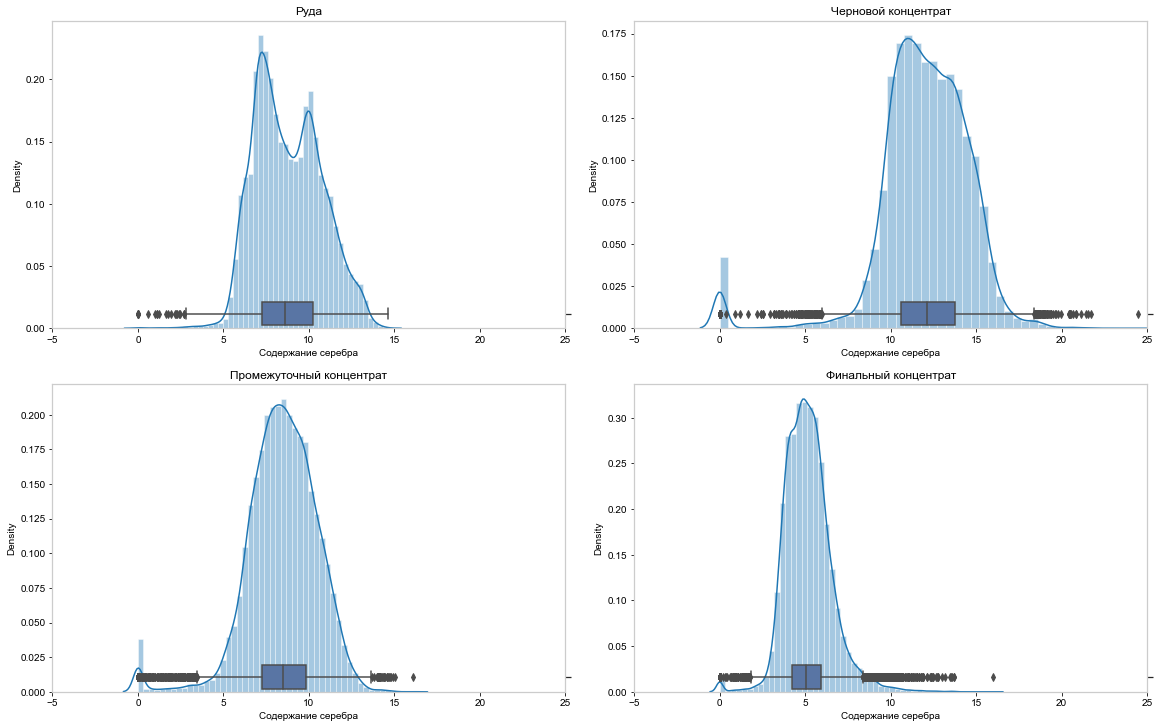

In [24]:
hists_plot(Ag, 'cеребра', xlim=(-5, 25))

На гистограммах отчётливо видно, что концентрация серебра по ходу тех.процесса обогащения неукоснительно уменьшается. Возможно, это специфика тех.процесса. Также видно, что на всех этапах данные имеют заметные выбросы. Правильней было бы их выделить в отдельный набор данных и изучить дополнительно. На текущем этапе мы этого делать не будем, как и удалать их

C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

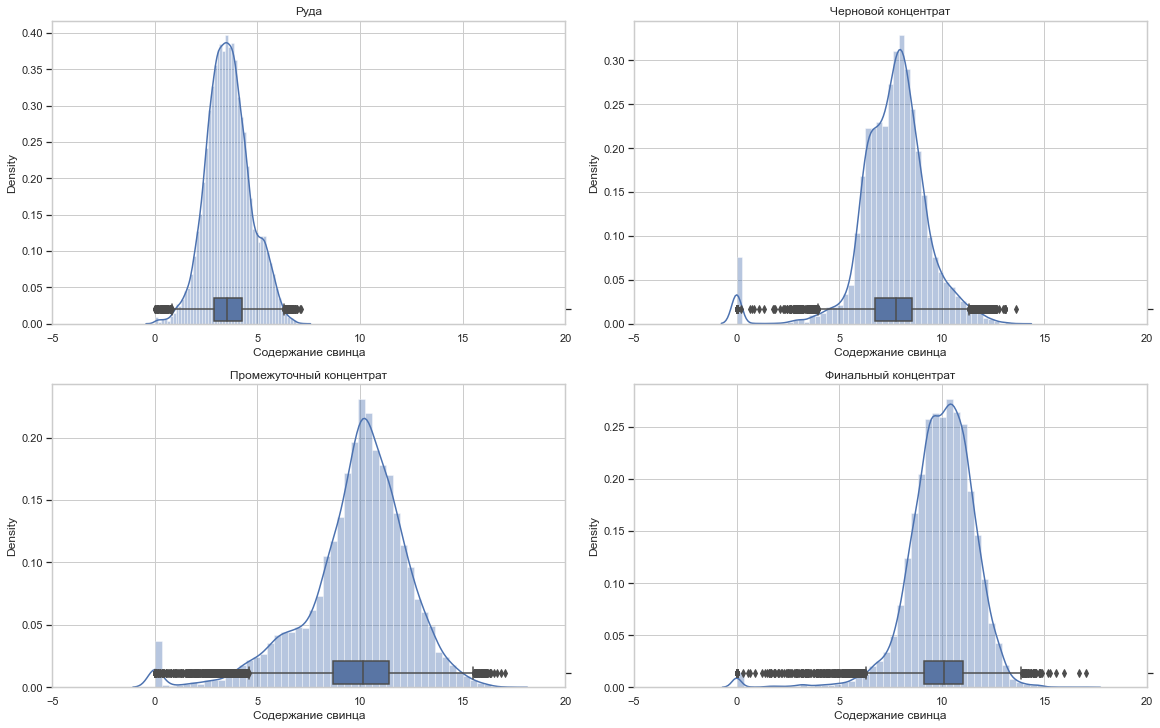

In [25]:
hists_plot(Pb, 'свинца', xlim=(-5, 20))

Концентрация свинца по ходу тех.процесса растёт, причем от руды до черновго концентрата -- скачкообразно. Данные также имеют выбросы, которые, также, удалять не будем

C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

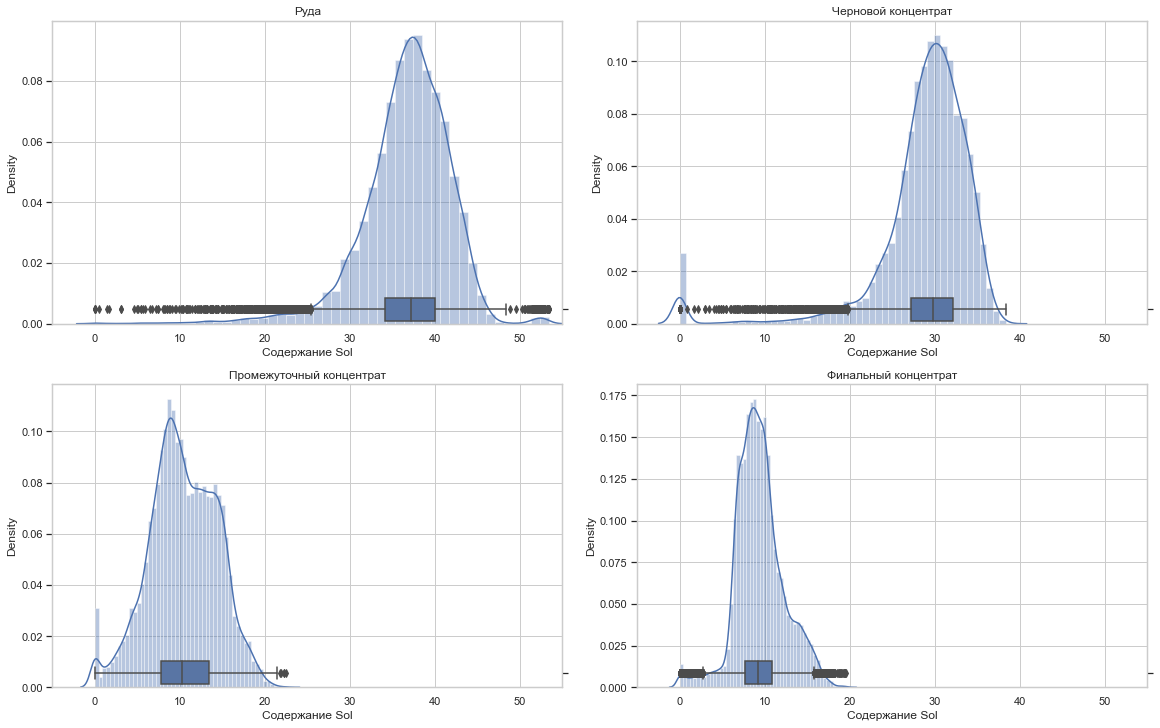

In [26]:
hists_plot(Sol, 'Sol', xlim=(-5, 55))

Концентрация Sol скачкообразно меняется на стадии руда-черновой концентрат, вероятно это также специфика тех.процесса. Данные также имеют выбросы, особенно для руды и финального концентрата, которые, также, удалять не будем

C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

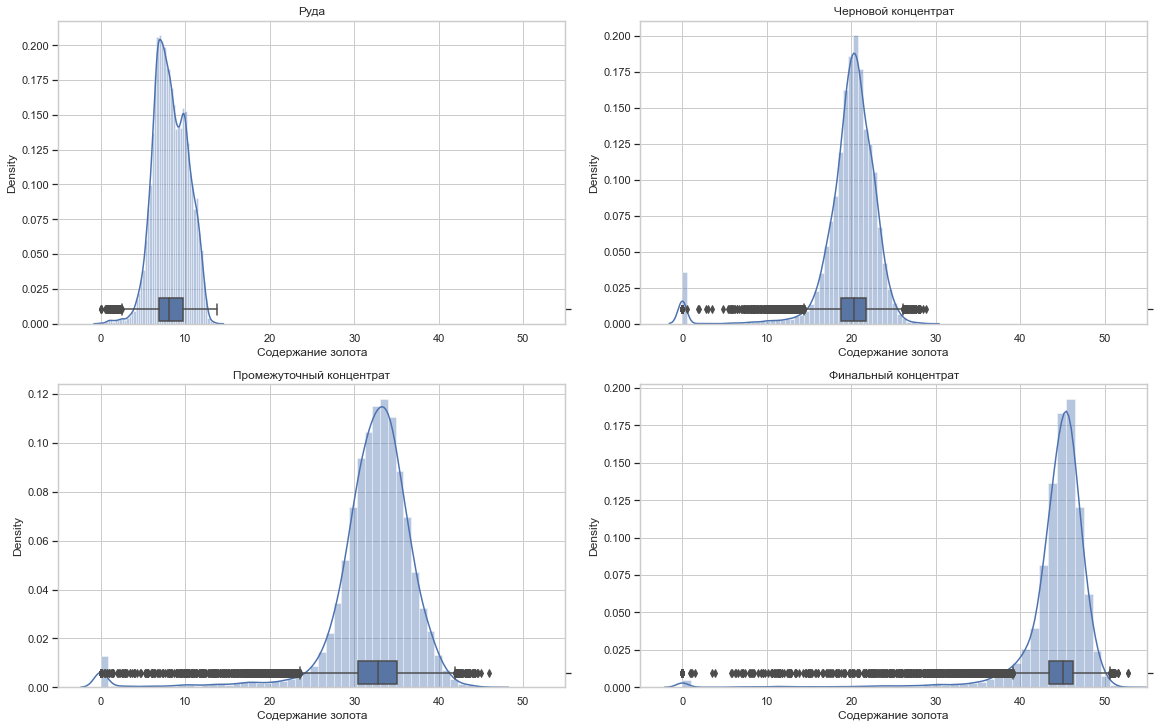

In [27]:
hists_plot(Au, 'золота', xlim=(-5, 55))

Концентрация золота по ходу тех.процесса неуклонно растёт, что, в общем-то, и является целью данного тех.процесса. Данные также имеют выбросы, которые, также, удалять не будем

### 2.2.3 Анализ распределения размеров гранул сырья на обучающей и тестовой выборках

C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

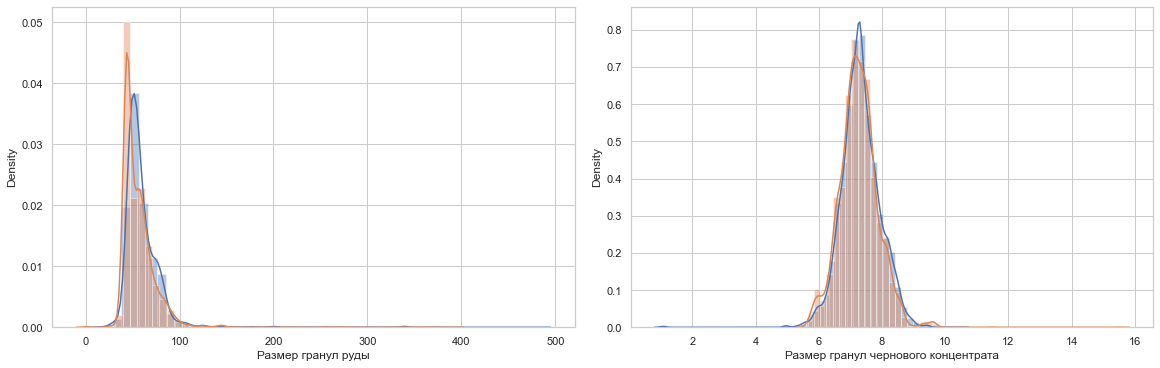

In [28]:
feed_hists_plot(bins=50, figsize=(16,5))

Гистограммы показывают, что распределение значений размеров гранул имеют заметное различие в выборках для гранул руды. Однако данное различие не является критическим, поскольку размах гистограмм очень близок.  
Гистограммы распределения значений размеров гранул чернового конденсата практически совпадают

### 2.2.4 Анализ суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом<font color=teal>, в промежуточном</font> и финальном концентратах

C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

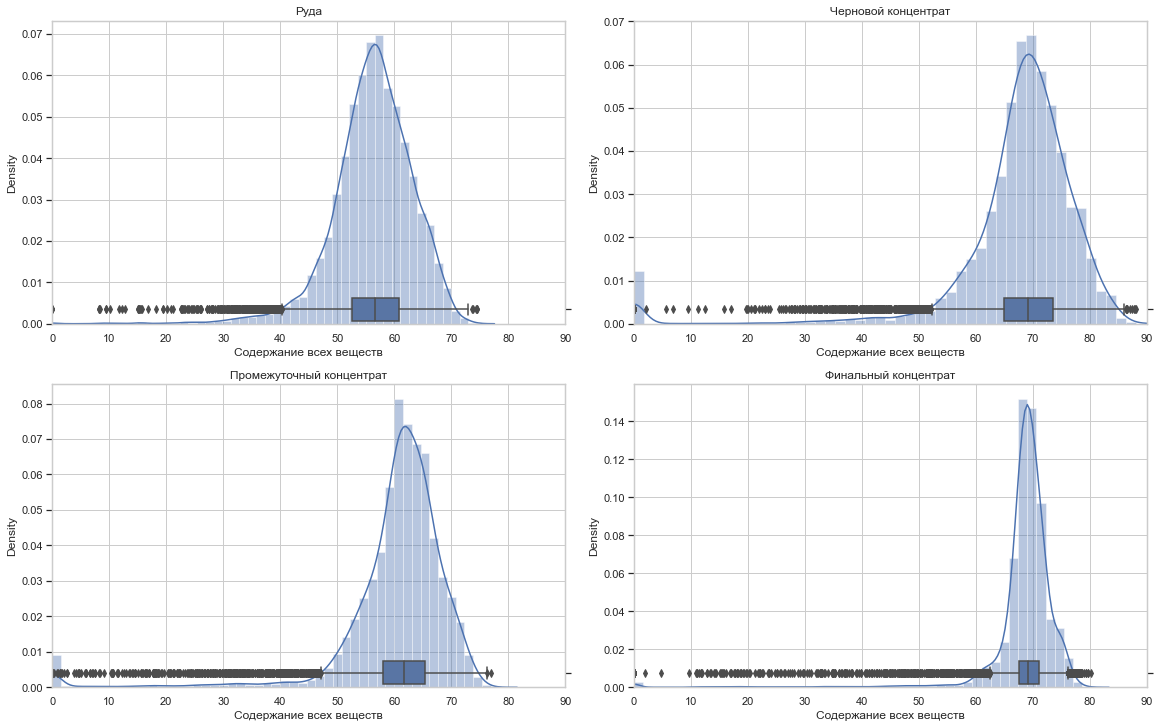

In [29]:
hists_plot([train_data['rougher.input.feed_ag'] + train_data['rougher.input.feed_pb'] +
            train_data['rougher.input.feed_sol'] + train_data['rougher.input.feed_au'],

            train_data['rougher.output.concentrate_ag'] + train_data['rougher.output.concentrate_pb'] +
            train_data['rougher.output.concentrate_sol'] + train_data['rougher.output.concentrate_au'],
            
            train_data['primary_cleaner.output.concentrate_ag'] + train_data['primary_cleaner.output.concentrate_pb'] +
            train_data['primary_cleaner.output.concentrate_sol'] + train_data['primary_cleaner.output.concentrate_au'],

            train_data['final.output.concentrate_ag'] + train_data['final.output.concentrate_pb'] +
            train_data['final.output.concentrate_sol'] + train_data['final.output.concentrate_au']],

           'всех веществ', xlim=(0, 90), sum_metal=True)

Гистограммы показывают, что по ходу протекания технологического процесса суммарная концентраця всех веществ сначала растёт, поскольку руда частично обогащается в результате флотации, а на финальных стадиях разброс значений (межквартильный размах) уменьшается, что говорит о том, что на финальных стадиях технологический процесс в подавляющем большинстве случаев заканчивается с выходом веществ с заданной концентрацией.  
  
Данные, ожидаемо, имеют выбросы. Спецификапереданных данных в том, что выбросы имеют значение и удалять их нельзя, поскольку являются вариантами реальных концентраций, значения которых будущая модель должна уметь предсказывать. Совсем бесполезными являются значения, близкие к нулю, которые мы и удалим.

In [30]:
train_data.loc[train_data['rougher.input.feed_ag'] <= 0.1, :] = None
train_data.loc[train_data['rougher.input.feed_pb'] <= 0.1, :] = None
train_data.loc[train_data['rougher.input.feed_sol'] <= 0.1, :] = None
train_data.loc[train_data['rougher.input.feed_au'] <= 0.1, :] = None
train_data.loc[train_data['rougher.output.concentrate_ag'] <= 0.1, :] = None
train_data.loc[train_data['rougher.output.concentrate_pb'] <= 0.1, :] = None
train_data.loc[train_data['rougher.output.concentrate_sol'] <= 0.1, :] = None
train_data.loc[train_data['rougher.output.concentrate_au'] <= 0.1, :] = None
train_data.loc[train_data['primary_cleaner.output.concentrate_ag'] <= 0.1, :] = None
train_data.loc[train_data['primary_cleaner.output.concentrate_pb'] <= 0.1, :] = None
train_data.loc[train_data['primary_cleaner.output.concentrate_sol'] <= 0.1, :] = None
train_data.loc[train_data['primary_cleaner.output.concentrate_au'] <= 0.1, :] = None
train_data.loc[train_data['final.output.concentrate_ag'] <= 0.1, :] = None
train_data.loc[train_data['final.output.concentrate_pb'] <= 0.1, :] = None
train_data.loc[train_data['final.output.concentrate_sol'] <= 0.1, :] = None
train_data.loc[train_data['final.output.concentrate_au'] <= 0.1, :] = None

train_data.dropna(inplace = True)

test_data.loc[test_data['rougher.input.feed_ag'] <= 0.1, :] = None
test_data.loc[test_data['rougher.input.feed_pb'] <= 0.1, :] = None
test_data.loc[test_data['rougher.input.feed_sol'] <= 0.1, :] = None
test_data.loc[test_data['rougher.input.feed_au'] <= 0.1, :] = None
test_data.loc[test_data['rougher.output.concentrate_ag'] <= 0.1, :] = None
test_data.loc[test_data['rougher.output.concentrate_pb'] <= 0.1, :] = None
test_data.loc[test_data['rougher.output.concentrate_sol'] <= 0.1, :] = None
test_data.loc[test_data['rougher.output.concentrate_au'] <= 0.1, :] = None
test_data.loc[test_data['primary_cleaner.output.concentrate_ag'] <= 0.1, :] = None
test_data.loc[test_data['primary_cleaner.output.concentrate_pb'] <= 0.1, :] = None
test_data.loc[test_data['primary_cleaner.output.concentrate_sol'] <= 0.1, :] = None
test_data.loc[test_data['primary_cleaner.output.concentrate_au'] <= 0.1, :] = None
test_data.loc[test_data['final.output.concentrate_ag'] <= 0.1, :] = None
test_data.loc[test_data['final.output.concentrate_pb'] <= 0.1, :] = None
test_data.loc[test_data['final.output.concentrate_sol'] <= 0.1, :] = None
test_data.loc[test_data['final.output.concentrate_au'] <= 0.1, :] = None

test_data.dropna(inplace = True)

C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NikitinAG\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

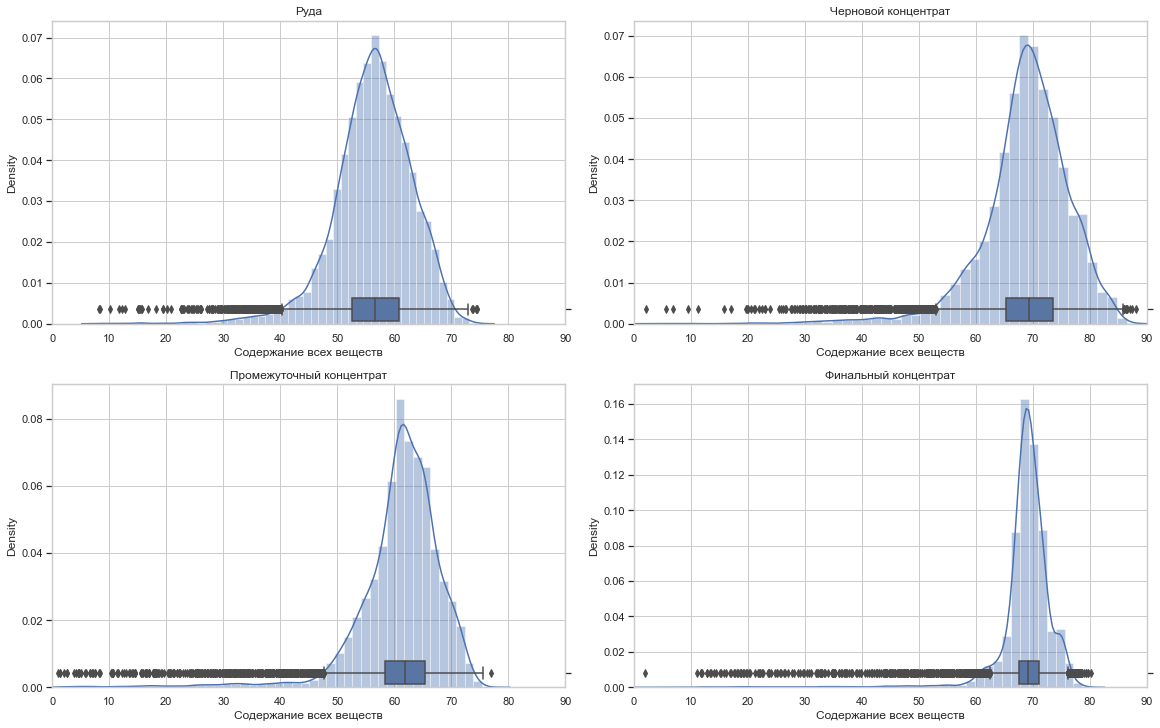

In [31]:
hists_plot([train_data['rougher.input.feed_ag'] + train_data['rougher.input.feed_pb'] +
            train_data['rougher.input.feed_sol'] + train_data['rougher.input.feed_au'],

            train_data['rougher.output.concentrate_ag'] + train_data['rougher.output.concentrate_pb'] +
            train_data['rougher.output.concentrate_sol'] + train_data['rougher.output.concentrate_au'],
            
            train_data['primary_cleaner.output.concentrate_ag'] + train_data['primary_cleaner.output.concentrate_pb'] +
            train_data['primary_cleaner.output.concentrate_sol'] + train_data['primary_cleaner.output.concentrate_au'],

            train_data['final.output.concentrate_ag'] + train_data['final.output.concentrate_pb'] +
            train_data['final.output.concentrate_sol'] + train_data['final.output.concentrate_au']],

           'всех веществ', xlim=(0, 90), sum_metal=True)

## 2.3 Построение и обучение моделей

In [32]:
test_columns

['date',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air'

In [33]:
train_targets = train_data.loc[:, ['rougher.output.recovery', 'final.output.recovery']]
train_features = train_data.loc[:, test_columns].drop(columns=['date'], axis='columns')

scorer = make_scorer(sMAPE)

**Линейная регрессия**

In [34]:
model = LinearRegression()
score = cross_val_score(model, train_features, train_targets, cv=5, scoring=scorer)
print("Score модели:", score.mean())

Score модели: 10.09130120670009


**Решающее дерево в регресии**

In [35]:
model = DecisionTreeRegressor(random_state=1457)
score = cross_val_score(model, train_features, train_targets, cv=5, scoring=scorer)
print("Score модели:", score.mean())

Score модели: 15.269692376484315


**Случайный лес в регрессии**

In [36]:
model = RandomForestRegressor(random_state=1457)
score = cross_val_score(model, train_features, train_targets, cv=5, scoring=scorer)
print("Score модели:", score.mean())

Score модели: 9.133471377434441


Ожидаемо лучший результат показал случайный лес.  
Постараемся улучшить качество моделей, подобрав более оптимальные гиперпараметры

In [37]:
results = [15.269692376484315, 0]

for i in range(1, 5):
    model = DecisionTreeRegressor(random_state=1457, max_depth=i)

    score = cross_val_score(model, train_features, train_targets, cv=5, scoring=scorer)

    if score.mean() < results[0]:
        results[0] = score.mean()
        results[1] = i

print('[Max sMAPE, max_depth]:', results)

[Max sMAPE, max_depth]: [9.286072649194804, 1]


In [38]:
results = [9.133471377434441, 0, 0]

for i in range(1, 3):
    for j in range(1, 10):
        model = RandomForestRegressor(random_state=1457, max_depth=i, n_estimators=j)

        score = cross_val_score(model, train_features, train_targets, cv=5, scoring=scorer)

        if score.mean() < results[0]:
            results[0] = score.mean()
            results[1] = i
            results[2] = j

print('[Max sMAPE, max_depth, n_estimators]:', results)

[Max sMAPE, max_depth, n_estimators]: [8.969289018377959, 1, 8]


Перебор гиперпараметров позволил немного улучшить качество моделей. Случайный лес показал лучшие результаты

## 2.4 Тестирование модели

In [39]:
test_targets = test_data.loc[:, ['rougher.output.recovery', 'final.output.recovery']]
test_features = test_data.loc[:, test_columns].drop(columns=['date'], axis='columns')

In [40]:
model = RandomForestRegressor(random_state=1457, max_depth=1, n_estimators=8)
model.fit(train_features, train_targets)

RandomForestRegressor(max_depth=1, n_estimators=8, random_state=1457)

In [41]:
print('sMAPE модели: {:.2f}'.format(sMAPE(test_targets, model.predict(test_features))))

sMAPE модели: 7.18


Отлично -- модель показала на тестовых данных результат лучше, при обучении.  
Проверим адекватность модели -- сравним её предиктные значения со значениями константной модели

In [42]:
const_model_predict = test_targets[['rougher.output.recovery', 'final.output.recovery']]
const_model_predict['rougher.output.recovery'] = train_targets['rougher.output.recovery'].mean()
const_model_predict['final.output.recovery'] = train_targets['final.output.recovery'].mean()

In [43]:
sMAPE(test_targets, const_model_predict)
print('sMAPE константной модели: {:.2f}'.format(sMAPE(test_targets, const_model_predict)))

sMAPE константной модели: 7.77


Получена модель случайного леса оказалась лучше константной, что говорит о её адекватности

# 3 Вывод

В ходе выполнения работы было сделано следующее.  
  
В соответствии с описанием технологического процесса, добытая руда проходит первичную обработку, в результате чего получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.  
  
Для упрощения ML-структуры технологического процесса (ТП) были объеденены фазы очистки в одну, считая их технологически эквивалентными. В результате данного допущения технологический процесс включает в себя две стадии:
- флотацию (с выходом чернового концентрата и отвала флотации);
- очистку (с выходом финального концентрата и отвала очистки).
  
Таким образом, ML-структура ТП включает в себя следущие модели:
- $m_1$ - модель предсказания содержания золота в черновом концентрате после флотации руды:
 - $C^m_{fl}$ -- прогнозируемое сдержание золота в черновом конденсате (предиктный признак, результат работы модели);
 - $f^P_1 ... f^P_n$ -- признаки, описывающие руду;
 - $C_{fl}$ -- целевой признак.  
   
- $m_3$ - модель предсказания содержания золота в отвале флотации:
 - $T^{m}_{fl}$ -- прогнозируемое сдержание золота в отвале флотации (предиктный признак, результат работы модели);
 - $f^{P}_1 ... f^{P}_n$ -- признаки, описывающие руду;
 - $T_{fl}$ -- целевой признак.   
   
- $m_2$ - модель предсказания содержания золота в финальном концентрате после очистки чернового конденсата:
 - $C^{m}_O$ -- прогнозируемое сдержание золота в финальном конденсате (предиктный признак, результат работы модели);
 - $f^{K}_1 ... f^{K}_z$ -- признаки, описывающие черновой концентрат;
 - $C_O$ -- целевой признак.  
  
- $m_4$ - модель предсказания содержания золота в отвале очистки:
 - $T^{m}_O$ -- прогнозируемое сдержание золота в отвале очистки (предиктный признак, результат работы модели);
 - $f^{K}_1 ... f^{K}_z$ -- признаки, описывающие черновой концентрат;
 - $T_O$ -- целевой признак.  
  
Иными словами, первый этап обработки руды описывается моделями $m_1$, $m_3$, а второй этап -- моделями $m_2$, $m_4$.  
  
Формулы расчёта эффективности обогащения тогда примут вид:
$$
Recovery_{fl}^m = \frac{C^m_{fl}\cdot\bigl(F_P-T^m_{fl}\bigr)}{F_P\cdot\bigl(C^m_{fl}-T^m_{fl}\bigr)}\cdot100\%
$$
  
$$
Recovery_O^m = \frac{C^m_O\cdot\bigl(F_K-T^m_O\bigr)}{F_K\cdot\bigl(C^m_O-T^m_O\bigr)}\cdot100\%
$$

При этом величины $Recovery_{fl}^m$ и $Recovery_O^m$ объединяют в себе предиктные значения моделей $m_1\dots m_4$, поэтому ML-структура тех.процесса может быть ещё упрощена, поскольку в переданных данных присутствуют значения $Recovery_{fl}^m$ (rougher.output.recovery) и $Recovery_O^m$ (final.output.recovery), которые, по большому счёту, можно было бы добавить в набор данных в случае их отсутствия.  

Инстурменты *sklearn* позволяют сосздавать мультивыходные модели машинного обучения, т.е. модели обучающиеся на нескольких целевых признаках и генерирующих, соответственно, несколько выходных предиктных признаков. Таким образом, модели $m_1\dots m_4$ вырождаются в одну модель с двумя целевеми и двумя предиктными (выходными) признаками.  

Полный набор признаков объектов находится в наборе данных *gold_recovery_full*. Поскольку обучаущий и тестовый набор передал Заказчик состав объектов должен им соответствовать. При этом переданные обучающий и тестовый наборы могут быть не полными в части ряда признаков. Поэтому предобработка данных была проведена на полном наборе данных, а затем были выделены из него обучающая и тестовая выборки по идентификаторам объектов в выборках, переданных Заказчиком. При этом состав признаков обучающей выборки приведём к составу признаков тестовой, поскольку в ней отстутствуют ряд признаков, которые формируются значительно позже.
  
Было выявлено, что в тестовой выборке недоступны некоторые расчетные (calculation) и выходные (output) характеристики процесса, т.к., по всей видимсоти, их невозможно получить/измерить во время протекания технологического процесса.
  
Затем была проведена предобработка данных, по результатам которой:
- выявлено, что пропуски отсутствуют только в столбцах *date* и *primary_cleaner.input.feed_size*; пропуски удалены в целевых признаках; остальные пропуски заполнены предыдущими по отношении к ним значениями;
- типы данных столбцов менять не требуется;
- дубликаты строк отсутствуют;
- сформированы новые обучающая и тестовая выборки из предобработанных значений полной выборки по идентификаторам строк выборок, переданных Заказчиком, с составом столбцов, соответствующих тестовой выборке
  
Затем была проеведена проверка правильности расчёта эффективности обогащения. Расчёт ведётся верно.  
  
Затем был проведён анализ изменения концентрации металлов (Au, Ag, Pb) на различных этапах обогащения.  
По результатам данного анализа были сделаны выводы:
- концентрация серебра по ходу тех.процесса обогащения неукоснительно уменьшается; возможно, это специфика тех.процесса; также видно, что на всех этапах данные имеют заметные выбросы;
- концентрация свинца по ходу тех.процесса растёт, причем от руды до черновго концентрата -- скачкообразно; данные также имеют выбросы;
- концентрация Sol скачкообразно меняется на стадии руда-черновой концентрат, вероятно это также специфика тех.процесса; данные также имеют выбросы, особенно для руды и финального концентрата;
- концентрация золота по ходу тех.процесса неуклонно растёт, что, в общем-то, и является целью данного тех.процесса; данные также имеют выбросы.
 
Далее был проведён анализ распределения размеров гранул сырья на обучающей и тестовой выборках.  
Анализ показал, что распределение значений размеров гранул имеют заметное различие в выборках для гранул руды. Однако данное различие не является критическим, поскольку размах гистограмм очень близок.  
Гистограммы распределения значений размеров гранул чернового конденсата практически совпадают.  
  
Далее был проведен анализ суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Анализ показал, что по ходу протекания технологического процесса суммарная концентраця всех веществ сначала растёт, поскольку руда частично обогащается в результате флотации, а на финальных стадиях разброс значений (межквартильный размах) уменьшается, что говорит о том, что на финальных стадиях технологический процесс в подавляющем большинстве случаев заканчивается с выходом веществ с заданной концентрацией.  
Данные, ожидаемо, имеют выбросы. Специфика переданных данных в том, что выбросы имеют значение и удалять их нельзя, поскольку являются вариантами реальных концентраций, значения которых будущая модель должна уметь предсказывать. Совсем бесполезными являются значения, близкие к нулю, которые были удалены.

Далее были построены и обучены модели **линейной регрессиия**, **решающего дерева в регресии** и **случайного леса в регрессии**. Ожидаемо лучший результат показал случайный лес. Качество моделей решающего дерева и случайного леса было улучшено перебором гиперматров. Случайный лес показал лучшие результаты.  
  
Далее было проведено тестирование модели -- модель показала на тестовых данных результат лучше, при обучении. Затем модель случайного леса проверили на адекватность -- получена модель оказалась лучше константной, что говорит о её адекватности
  
***Таким образом, прототипом модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды является модель случайного леса в регрессии***  
 `'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 1,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 8,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1457,
 'verbose': 0,
 'warm_start': False`